This notebook will explore the temporal patterns in the taxi dataset.
Some part of the code is borrowed from https://www.kaggle.com/selfishgene/yellow-cabs-tell-the-story-of-new-york-city

The taxi data shows a lot of unique patterns by hours, week, season. In our case, the data provided is for 6 months, so we can properly analyse the hourly and weekly trends. 

In [286]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import seaborn as sns
import scipy.stats as sc
import datetime as dt
import shapely as sh
import geopandas as gp
import pysal as ps
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, pdist

%matplotlib inline

In [197]:
def remove_central_park(data,ct):

    data.to_file("./Cleaned_data/" + ct + ".shp")
    filepath ="./Cleaned_data/" + ct + ".shp"

    W = ps.queen_from_shapefile(filepath, idVariable='BoroCT2010')

    cp_neigh = W.neighbors[1014300]

    val1 = int(data[data.BoroCT2010 == 1014300].id / len(cp_neigh))

    data.set_index('BoroCT2010', inplace=True)

    for cp_n in cp_neigh:
        data.loc[cp_n, 'id'] = data.loc[cp_n, 'id'] + val1
    

    data.reset_index(inplace=True)

    ## Remove central park from the dataset
    data.drop(data[data.BoroCT2010 == 1014300].index, axis=0, inplace=True)

    return data

In [198]:
def aggregator_by_ct(data1, ct):
    ''''''
    data1 = data1.groupby(ct).agg({'id':'count', 'trip_duration':'median'})
    data1.reset_index(inplace=True)
    data1 = get_ct_geometry(data1, ct)
    
    ## Remove central park
    data1 = remove_central_park(data1, ct)
    
    return data1

In [199]:
def get_ct_geometry(data, ct):
    '''Data should have column - BoroCT2010'''

    nyct = gp.read_file("./nyct2010_17c/nyct2010.shp")
    nyct.to_crs(epsg=4326, inplace=True)
    nyct = nyct[['BoroCT2010', 'BoroName', 'geometry']]
    nyct.BoroCT2010 = nyct.BoroCT2010.astype('int64')
    data = pd.merge(data, nyct, left_on=ct, right_on='BoroCT2010', how='left')
    crs = {'init': 'epsg:4326', 'no_defs': True}
    data = gp.GeoDataFrame(data, crs=crs, geometry=data.geometry)
    return data

In [153]:
train = pd.read_csv("./Cleaned_data/train_combined.csv")

# Converting datetime columns dtype from object to datetime
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train.drop(['Unnamed: 0'], axis=1, inplace=True)

train['phourofday'] = train.pickup_datetime.dt.hour
train['dhourofday'] = train.dropoff_datetime.dt.hour
train['dayofweek'] = train.pickup_datetime.dt.dayofweek

In [154]:
nyct = gp.read_file("./nyct2010_17c/nyct2010.shp")
nyct.to_crs(epsg=4326, inplace=True)
nyct = nyct[['BoroCT2010', 'BoroName', 'geometry']]
nyct.BoroCT2010 = nyct.BoroCT2010.astype('int64')
nyct = nyct[nyct.BoroName == 'Manhattan']

In [155]:
tp = pd.read_csv("./Cleaned_data/tp_full.csv")
tp.drop(['Unnamed: 0'], axis=1, inplace=True)

td = pd.read_csv("./Cleaned_data/td_full.csv")
td.drop(['Unnamed: 0'], axis=1, inplace=True)

In [156]:
tp = pd.merge(tp, nyct, on='BoroCT2010').rename(columns={'BoroCT2010':'pickup_ct'}).drop(['BoroName', 'geometry'], axis=1)
td = pd.merge(td, nyct, on='BoroCT2010').rename(columns={'BoroCT2010':'dropoff_ct'}).drop(['BoroName', 'geometry'], axis=1)

In [157]:
train = pd.merge(train, tp, on='id', how='inner')
train = pd.merge(train, td, on='id', how='inner')

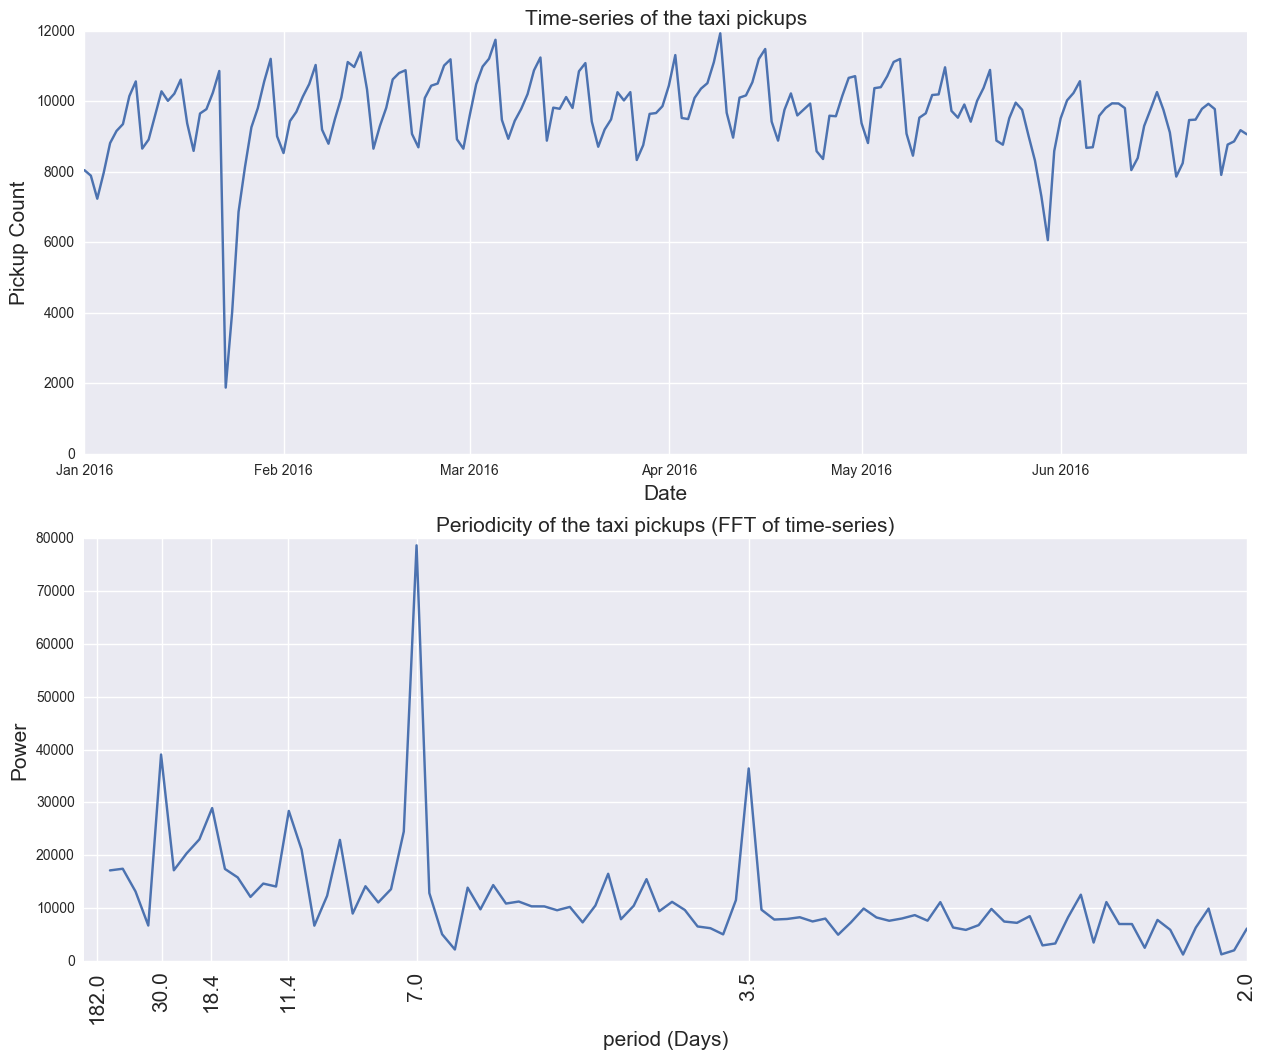

In [131]:
train_daily = train.set_index('pickup_datetime').groupby([pd.TimeGrouper('D')]).agg({'id':'count'})

fig=plt.figure(figsize=(15,12))

ax2=plt.subplot(211)
ax2.plot(train_daily.index, train_daily.id, '-')
ax2.set_title('Time-series of the taxi pickups', fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Pickup Count", fontsize=15)

train_daily.reset_index(inplace=True)
f =pd.DataFrame(np.abs(np.fft.rfft(train_daily.id)))
f = f.iloc[2:,:]

sample_rate = 1
duration = 182

N = duration * sample_rate
freq = 1.0 / duration
period = 1.0 / freq


ax1=plt.subplot(212)
ax1.plot(np.fft.rfftfreq(N, 1.0)[2:], ((f)), '-')
ax1.set_xticks([1./182, 1./30, 1./18.4, 1./11.4, 1./7,1./3.5,0.5])
ax1.set_xticklabels([ "%s"%(1/m) for m in ax1.get_xticks()], 
                   rotation=90, fontsize=15)
ax1.set_title('Periodicity of the taxi pickups (FFT of time-series)', fontsize=15)
plt.xlabel("period (Days)", fontsize=15)
plt.ylabel("Power", fontsize=15)

Figure 1: The time series of the pickups shows that there were 2 dips, one was the blizzard around 27the January and other dip is on 28th May. which is the Memorial day. To find the periodicity in the taxi trips, I have taken the Fast fourier transform. 
The power spectrum of the pickups shows that in NYC the pickups are preodic at weekly basis. There is a repeating pattern at each week and another repeating pattern at each month. There is another interesting pattern around 3.5 days

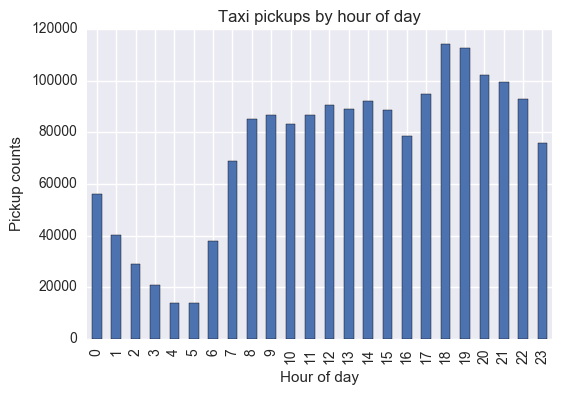

In [132]:
a= train.groupby('phourofday').size()
a.plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel("Pickup counts")
plt.title("Taxi pickups by hour of day")

Figure 2: The above figure tells us that the taxis are mostly used in Manhattan during the day and evening.

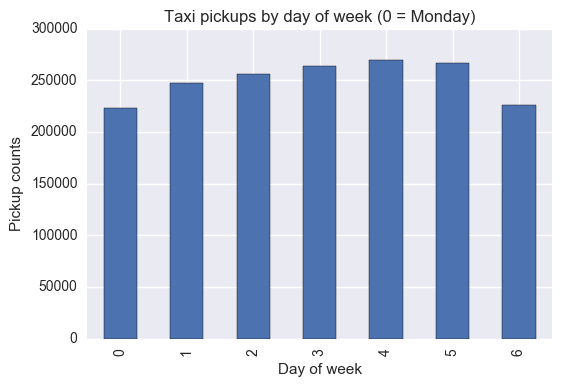

In [133]:
a= train.groupby('dayofweek').size()
a.plot(kind='bar')
plt.xlabel('Day of week')
plt.ylabel("Pickup counts")
plt.title("Taxi pickups by day of week (0 = Monday)")

Figure 3: The above figure tells us that the taxis are used more in Manhattan during the week and Friday, Saturday.

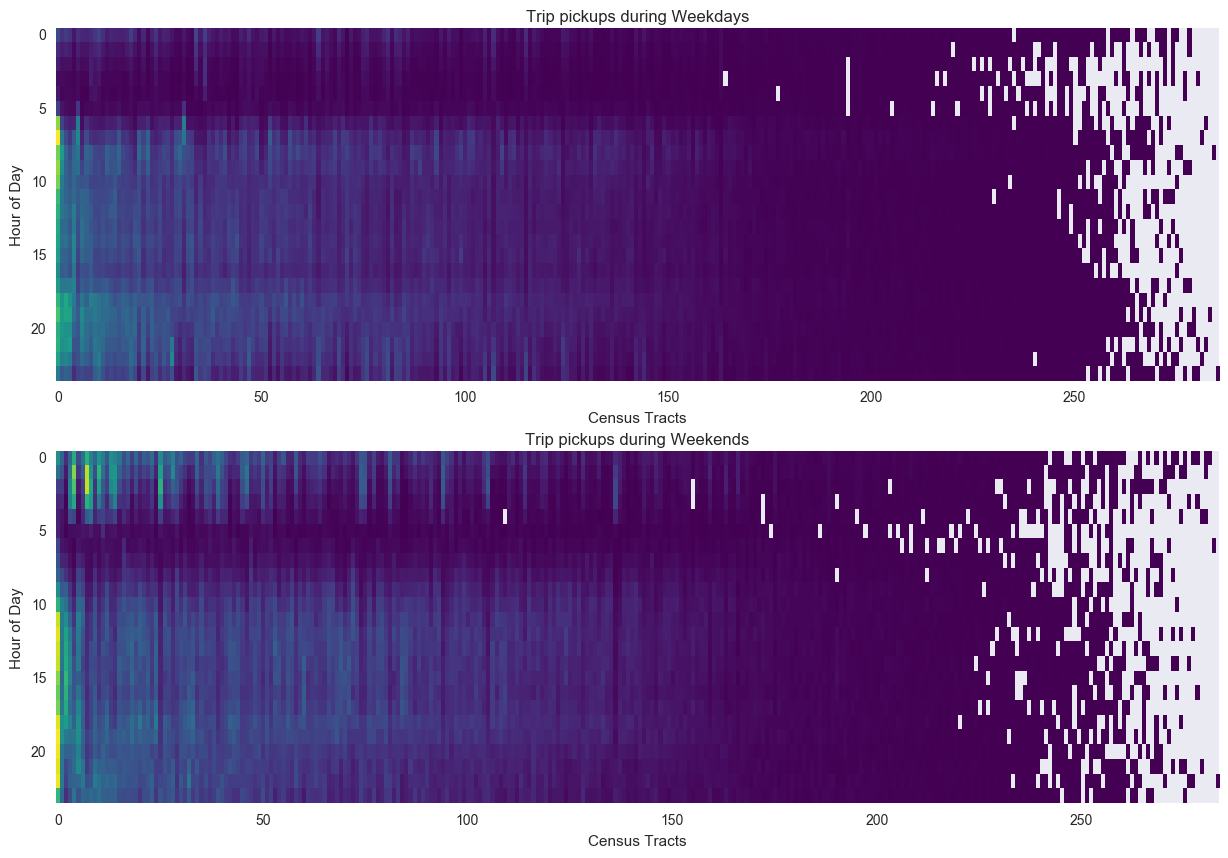

In [134]:
t = train[train['dayofweek'] <= 4].groupby(['pickup_ct', 'phourofday']).agg({'id':'count'}).reset_index('phourofday')
t = t.pivot_table(index = 'pickup_ct', columns='phourofday', values='id')
t['sum'] = t.sum(axis=1)
cTDistributionHourOfDay_weekday = t.sort_index(by='sum', ascending=False).drop('sum', axis=1).transpose().as_matrix()

te = train[train['dayofweek'] >= 5].groupby(['pickup_ct', 'phourofday']).agg({'id':'count'}).reset_index('phourofday')
te = te.pivot_table(index = 'pickup_ct', columns='phourofday', values='id')
te['sum'] = te.sum(axis=1)
cTDistributionHourOfDay_weekend = te.sort_index(by='sum', ascending=False).drop('sum', axis=1).transpose().as_matrix()

plt.figure(figsize=(15,10))
ax1 = plt.subplot(2,1,1)
ax1.set_title('Trip pickups during Weekdays', fontsize=12)
ax1.imshow(cTDistributionHourOfDay_weekday, cmap = 'viridis', interpolation='nearest', aspect='auto')
ax1.grid('off')
ax1.set_xlabel('Census Tracts')
ax1.set_ylabel('Hour of Day')

ax2 = plt.subplot(2,1,2)
ax2.set_title('Trip pickups during Weekends', fontsize=12)
ax2.imshow(cTDistributionHourOfDay_weekend, cmap='viridis', interpolation='nearest', aspect='auto')
ax2.grid('off')
ax2.set_xlabel('Census Tracts')
ax2.set_ylabel('Hour of Day')

Figure 4: In the above figures, light colour represents higher pickups. The figures show that most census tracts have higher pickups during day time starting from around 6am in morning during weekdays. During weekends, there are more pickups during 12am to 5 am. These census tracts may be the areas with bars where people party during weekends. The white points are Null values.  

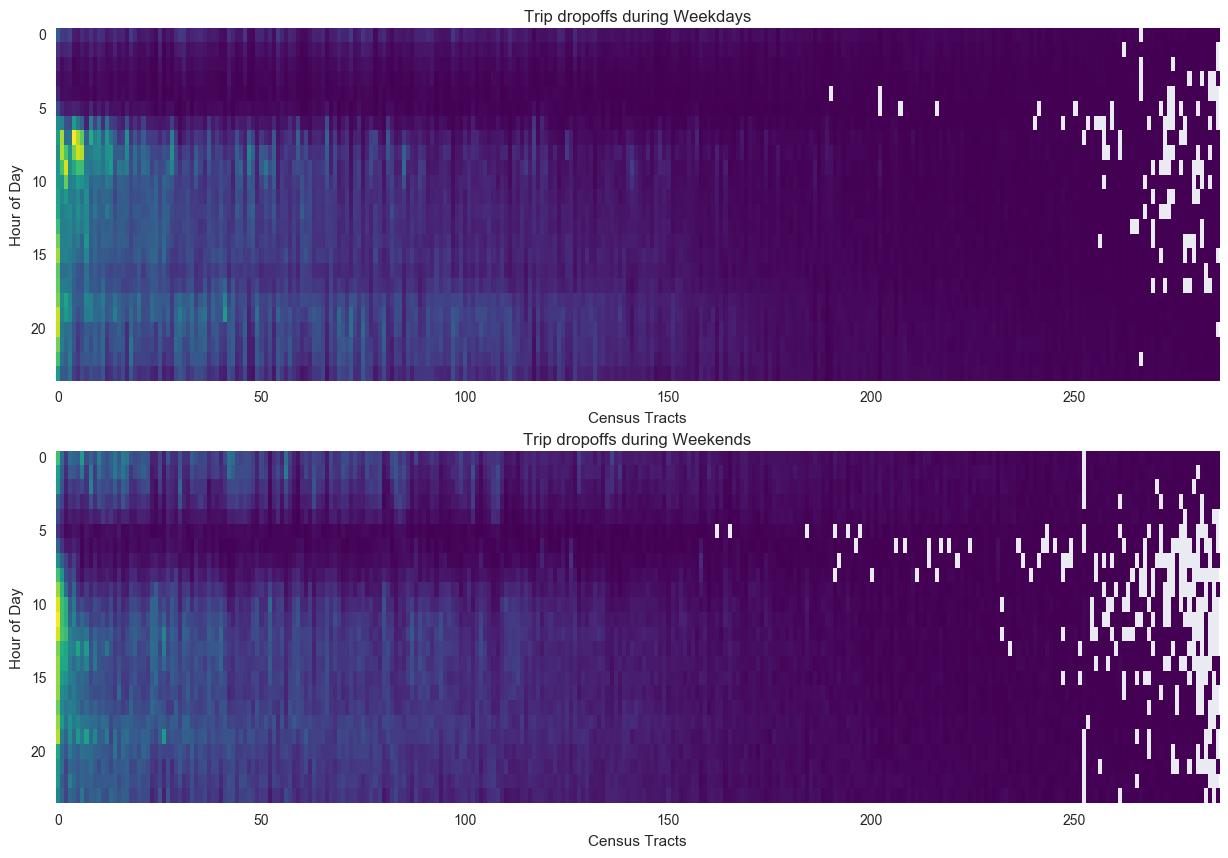

In [135]:
t = train[train['dayofweek'] <= 4].groupby(['dropoff_ct', 'dhourofday']).agg({'id':'count'}).reset_index('dhourofday')
t = t.pivot_table(index = 'dropoff_ct', columns='dhourofday', values='id')
t['sum'] = t.sum(axis=1)
cTDistributionHourOfDay_weekday_d = t.sort_index(by='sum', ascending=False).drop('sum', axis=1).transpose().as_matrix()

te = train[train['dayofweek'] >= 5].groupby(['dropoff_ct', 'dhourofday']).agg({'id':'count'}).reset_index('dhourofday')
te = te.pivot_table(index = 'dropoff_ct', columns='dhourofday', values='id')
te['sum'] = te.sum(axis=1)
cTDistributionHourOfDay_weekend_d = te.sort_index(by='sum', ascending=False).drop('sum', axis=1).transpose().as_matrix()

plt.figure(figsize=(15,10))
ax1 = plt.subplot(2,1,1)
ax1.set_title('Trip dropoffs during Weekdays', fontsize=12)
ax1.imshow(cTDistributionHourOfDay_weekday_d, cmap = 'viridis', interpolation='nearest', aspect='auto')
ax1.grid('off')
ax1.set_xlabel('Census Tracts')
ax1.set_ylabel('Hour of Day')

ax2 = plt.subplot(2,1,2)
ax2.set_title('Trip dropoffs during Weekends', fontsize=12)
ax2.imshow(cTDistributionHourOfDay_weekend_d, cmap='viridis', interpolation='nearest', aspect='auto')
ax2.grid('off')
ax2.set_xlabel('Census Tracts')
ax2.set_ylabel('Hour of Day')

Figure 5: In the above figures, light colour represents higher dropoffs. The figures show that most census tracts have higher dropoffs during day time starting from around 6am in morning during weekdays. During weekends, there are higher dropoffs during 12am to 5 am. These census tracts may be the areas with bars where people party during weekends. The white points are Null values. 

The above figures have given an idea about the temporal taxi usage. The next part would be to visualize these areas on maps and get an understanding of the areas. Before that lets summarize what we have understood from the data:

* The taxi pickup and dropoff trends during the weekdays are different from the weekend
* There are some census tracts which have high taxi usage during weekdays, these areas may be residential, business and scenic areas which tourists visit.
* Some areas have bars and parties, these census tracts have pickups durig late nights

Once we identify these individual areas (high pickup, dropoff, party zones), we can analyse the characteristics of these areas (understand whether they are residential/business area) and this data can help  to show proper advertisment to the potential consumers. 

Areas with bars, attract a specific type of crowd, where specific advertisments can be shown
If the area has large pickups, advertisment for customers like Uber, Lyft, Via can be profitable.
Taxi top advertisments can be decided based in the areas where it is visiting (if they are made digitial and dynamic) 

Now, lets visualize these areas on map

In [357]:
morning_pickups_wd = train[(train.phourofday >= 7) & (train.phourofday <= 11) & (train.dayofweek <= 4)]
afternoon_pickups_wd = train[(train.phourofday >= 12) & (train.phourofday <= 16) & (train.dayofweek <= 4)]
evening_pickups_wd = train[(train.phourofday >=17 ) & (train.phourofday <= 23) & (train.dayofweek <= 4)]
night_pickups_wd = train[(train.phourofday >=0 ) & (train.phourofday <= 6) & (train.dayofweek <= 4)]

morning_dropoffs_wd = train[(train.dhourofday >= 7) & (train.dhourofday <= 11) & (train.dayofweek <= 4)]
afternoon_dropoffs_wd = train[(train.dhourofday >= 12) & (train.dhourofday <= 16) & (train.dayofweek <= 4)]
evening_dropoffs_wd = train[(train.dhourofday >=17 ) & (train.dhourofday <= 23) & (train.dayofweek <= 4)]
night_dropoffs_wd = train[(train.dhourofday >=0 ) & (train.dhourofday <= 6) & (train.dayofweek <= 4)]

morning_pickups_we = train[(train.phourofday >= 7) & (train.phourofday <= 11) & (train.dayofweek >= 5)]
afternoon_pickups_we = train[(train.phourofday >= 12) & (train.phourofday <= 16) & (train.dayofweek >= 5)]
evening_pickups_we = train[(train.phourofday >=17 ) & (train.phourofday <= 23) & (train.dayofweek >= 5)]
night_pickups_we = train[(train.phourofday >=0 ) & (train.phourofday <= 6) & (train.dayofweek >= 5)]

morning_dropoffs_we = train[(train.dhourofday >= 7) & (train.dhourofday <= 11) & (train.dayofweek >= 5)]
afternoon_dropoffs_we = train[(train.dhourofday >= 12) & (train.dhourofday <= 16) & (train.dayofweek >= 5)]
evening_dropoffs_we = train[(train.dhourofday >=17 ) & (train.dhourofday <= 23) & (train.dayofweek >= 5)]
night_dropoffs_we = train[(train.dhourofday >=0 ) & (train.dhourofday <= 6) & (train.dayofweek >= 5)]

In [359]:
morning_pickups_wd = aggregator_by_ct(morning_pickups_wd, 'pickup_ct')
afternoon_pickups_wd = aggregator_by_ct(afternoon_pickups_wd, 'pickup_ct')
evening_pickups_wd = aggregator_by_ct(evening_pickups_wd, 'pickup_ct')
night_pickups_wd = aggregator_by_ct(night_pickups_wd, 'pickup_ct')

morning_dropoffs_wd = aggregator_by_ct(morning_dropoffs_wd, 'dropoff_ct')
afternoon_dropoffs_wd = aggregator_by_ct(afternoon_dropoffs_wd, 'dropoff_ct')
evening_dropoffs_wd = aggregator_by_ct(evening_dropoffs_wd, 'dropoff_ct')
night_dropoffs_wd = aggregator_by_ct(night_dropoffs_wd, 'dropoff_ct')

morning_pickups_we = aggregator_by_ct(morning_pickups_we, 'pickup_ct')
afternoon_pickups_we = aggregator_by_ct(afternoon_pickups_we, 'pickup_ct')
evening_pickups_we = aggregator_by_ct(evening_pickups_we, 'pickup_ct')
night_pickups_we = aggregator_by_ct(night_pickups_we, 'pickup_ct')

morning_dropoffs_we = aggregator_by_ct(morning_dropoffs_we, 'dropoff_ct')
afternoon_dropoffs_we = aggregator_by_ct(afternoon_dropoffs_we, 'dropoff_ct')
evening_dropoffs_we = aggregator_by_ct(evening_dropoffs_we, 'dropoff_ct')
night_dropoffs_we = aggregator_by_ct(night_dropoffs_we, 'dropoff_ct')

In [206]:
def plot_2_maps(data1, data2, data1_title, data2_title):
    
    plt.figure(figsize=(15,10))
    
    data1 = data1[data1.BoroCT2010 != 1010100]
    data2 = data2[data2.BoroCT2010 != 1010100]
    
    data1.id = (data1.id - data1.id.mean())/data1.id.std()
    data2.id = (data2.id - data2.id.mean())/data2.id.std()
        
    if data1.id.min() < data2.id.min():
        vmin = data1.id.min()
    else:
        vmin = data2.id.min()
        
    if data1.id.max() > data2.id.max():
        vmax = data1.id.max()
    else:
        vmax = data2.id.max()
    
    ax1 = plt.subplot(1,2,1)
    
    data1.plot(column='id', colormap='hot_r', vmin=vmin, vmax=vmax, linewidth = 0.1, alpha = 1, ax=ax1)


    fig = ax1.get_figure()
    cax = fig.add_axes([0.45, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cax)
    ax1.set_title(data1_title)
    ax1.set_axis_off()

    ax2 = plt.subplot(1,2,2)
    
    vmax2 = data2.id.max()
    vmin2 = data2.id.min()
    
    data2.plot(column='id', colormap='hot_r', vmin=vmin, vmax=vmax, linewidth = 0.1, alpha = 1, ax=ax2)
    

    fig2 = ax2.get_figure()
    cax2 = fig2.add_axes([0.9, 0.1, 0.03, 0.8])

    sm2 = plt.cm.ScalarMappable(cmap='hot_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm2._A = []
    ax2.set_title(data2_title)
    ax2.set_axis_off()
    fig2.colorbar(sm2, cax=cax2)

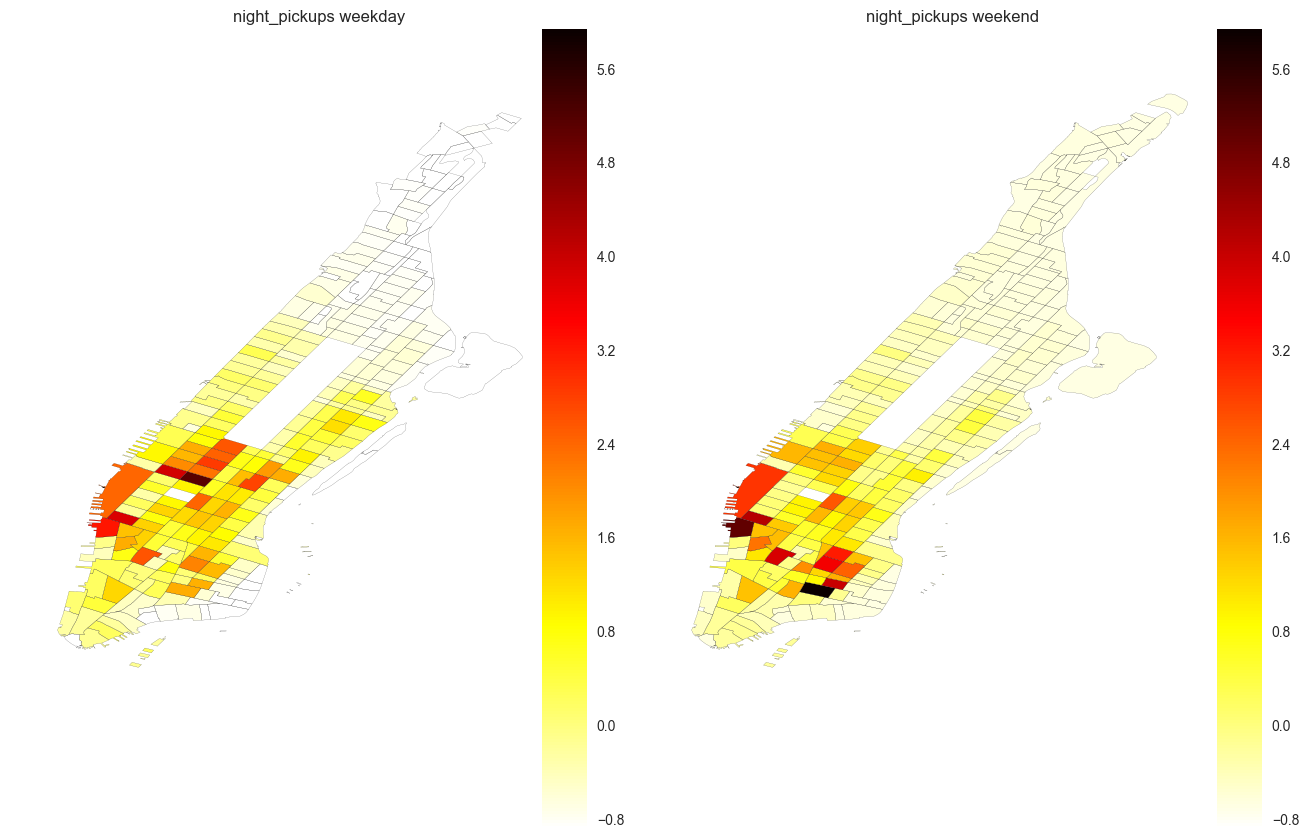

In [360]:
## Other combinations can be created as well
plot_2_maps(night_pickups_wd, night_pickups_we, 'night_pickups weekday', 'night_pickups weekend')

The above maps show the pickups at night during weekday and weekend, the data is standardised for visualizing. It can be seen clearly that during weekends, the pickups at night are near places with bars and parties.

I have not plotted all the combinations of the temporal datasets, since they are too many. But the data is used to find clusters 

In [220]:
morning_pickups_wd.to_file("./Temporal/morning_pickups_wd.shp") 
afternoon_pickups_wd.to_file("./Temporal/afternoon_pickups_wd.shp")
evening_pickups_wd.to_file("./Temporal/evening_pickups_wd.shp")
night_pickups_wd.to_file("./Temporal/night_pickups_wd.shp")

morning_dropoffs_wd.to_file("./Temporal/morning_dropoffs_wd.shp")
afternoon_dropoffs_wd.to_file("./Temporal/afternoon_dropoffs_wd.shp")
evening_dropoffs_wd.to_file("./Temporal/evening_dropoffs_wd.shp")
night_dropoffs_wd.to_file("./Temporal/night_dropoffs_wd.shp")

morning_pickups_we.to_file("./Temporal/morning_pickups_we.shp")
afternoon_pickups_we.to_file("./Temporal/afternoon_pickups_we.shp")
evening_pickups_we.to_file("./Temporal/evening_pickups_we.shp")
night_pickups_we.to_file("./Temporal/night_pickups_we.shp")

morning_dropoffs_we.to_file("./Temporal/morning_dropoffs_we.shp")
afternoon_dropoffs_we.to_file("./Temporal/afternoon_dropoffs_we.shp")
evening_dropoffs_we.to_file("./Temporal/evening_dropoffs_we.shp")
night_dropoffs_we.to_file("./Temporal/night_dropoffs_we.shp")

In [239]:
morning_pickups_wd.rename(columns={'id':'morning_pickups_wd', 
                                   'trip_duration': 'morning_pickups_wd_trip_dur'}, inplace=True)
afternoon_pickups_wd.rename(columns={'id':'afternoon_pickups_wd',
                                    'trip_duration': 'afternoon_pickups_wd_trip_dur'}, inplace=True)
evening_pickups_wd.rename(columns={'id':'evening_pickups_wd',
                                  'trip_duration': 'evening_pickups_wd_trip_dur'}, inplace=True)
night_pickups_wd.rename(columns={'id':'night_pickups_wd',
                                'trip_duration': 'night_pickups_wd_trip_dur'}, inplace=True)

morning_dropoffs_wd.rename(columns={'id':'morning_dropoffs_wd',
                                   'trip_duration': 'morning_dropoffs_wd_trip_dur'}, inplace=True)
afternoon_dropoffs_wd.rename(columns={'id':'afternoon_dropoffs_wd',
                                     'trip_duration': 'afternoon_dropoffs_wd_trip_dur'}, inplace=True)
evening_dropoffs_wd.rename(columns={'id':'evening_dropoffs_wd',
                                   'trip_duration': 'evening_dropoffs_wd_trip_dur'}, inplace=True)
night_dropoffs_wd.rename(columns={'id':'night_dropoffs_wd',
                                 'trip_duration': 'night_dropoffs_wd_trip_dur'}, inplace=True)

morning_pickups_we.rename(columns={'id':'morning_pickups_we',
                                  'trip_duration': 'morning_pickups_we_trip_dur'}, inplace=True)
afternoon_pickups_we.rename(columns={'id':'afternoon_pickups_we',
                                    'trip_duration': 'afternoon_pickups_we_trip_dur'}, inplace=True)
evening_pickups_we.rename(columns={'id':'evening_pickups_we',
                                  'trip_duration': 'evening_pickups_we_trip_dur'}, inplace=True)
night_pickups_we.rename(columns={'id':'night_pickups_we',
                                'trip_duration': 'night_pickups_we_trip_dur'}, inplace=True)

morning_dropoffs_we.rename(columns={'id':'morning_dropoffs_we',
                                   'trip_duration': 'morning_dropoffs_we_trip_dur'}, inplace=True)
afternoon_dropoffs_we.rename(columns={'id':'afternoon_dropoffs_we',
                                     'trip_duration': 'afternoon_dropoffs_we_trip_dur'}, inplace=True)
evening_dropoffs_we.rename(columns={'id':'evening_dropoffs_we',
                                   'trip_duration': 'evening_dropoffs_we_trip_dur'}, inplace=True)
night_dropoffs_we.rename(columns={'id':'night_dropoffs_we',
                                 'trip_duration': 'night_dropoffs_we_trip_dur'}, inplace=True)

In [247]:
morning_pickups_wd.drop(['pickup_ct'], axis=1, inplace=True)
afternoon_pickups_wd.drop(['pickup_ct'], axis=1, inplace=True)
evening_pickups_wd.drop(['pickup_ct'], axis=1, inplace=True)
night_pickups_wd.drop(['pickup_ct'], axis=1, inplace=True)

morning_dropoffs_wd.drop(['dropoff_ct'], axis=1, inplace=True)
afternoon_dropoffs_wd.drop(['dropoff_ct'], axis=1, inplace=True)
evening_dropoffs_wd.drop(['dropoff_ct'], axis=1, inplace=True)
night_dropoffs_wd.drop(['dropoff_ct'], axis=1, inplace=True)

morning_pickups_we.drop(['pickup_ct'], axis=1, inplace=True)
afternoon_pickups_we.drop(['pickup_ct'], axis=1, inplace=True)
evening_pickups_we.drop(['pickup_ct'], axis=1, inplace=True)
night_pickups_we.drop(['pickup_ct'], axis=1, inplace=True)

morning_dropoffs_we.drop(['dropoff_ct'], axis=1, inplace=True)
afternoon_dropoffs_we.drop(['dropoff_ct'], axis=1, inplace=True)
evening_dropoffs_we.drop(['dropoff_ct'], axis=1, inplace=True)
night_dropoffs_we.drop(['dropoff_ct'], axis=1, inplace=True)



morning_pickups_wd.drop(['BoroName', 'geometry'], axis=1, inplace=True)
afternoon_pickups_wd.drop(['BoroName', 'geometry'], axis=1, inplace=True)
evening_pickups_wd.drop(['BoroName', 'geometry'], axis=1, inplace=True)
night_pickups_wd.drop(['BoroName', 'geometry'], axis=1, inplace=True)

morning_dropoffs_wd.drop(['BoroName', 'geometry'], axis=1, inplace=True)
afternoon_dropoffs_wd.drop(['BoroName', 'geometry'], axis=1, inplace=True)
evening_dropoffs_wd.drop(['BoroName', 'geometry'], axis=1, inplace=True)
night_dropoffs_wd.drop(['BoroName', 'geometry'], axis=1, inplace=True)

morning_pickups_we.drop(['BoroName', 'geometry'], axis=1, inplace=True)
afternoon_pickups_we.drop(['BoroName', 'geometry'], axis=1, inplace=True)
evening_pickups_we.drop(['BoroName', 'geometry'], axis=1, inplace=True)
night_pickups_we.drop(['BoroName', 'geometry'], axis=1, inplace=True)

morning_dropoffs_we.drop(['BoroName', 'geometry'], axis=1, inplace=True)
afternoon_dropoffs_we.drop(['BoroName', 'geometry'], axis=1, inplace=True)
evening_dropoffs_we.drop(['BoroName', 'geometry'], axis=1, inplace=True)
night_dropoffs_we.drop(['BoroName', 'geometry'], axis=1, inplace=True)


In [295]:
temporal = pd.merge(morning_pickups_wd, 
         afternoon_pickups_wd, 
         on='BoroCT2010')\
.merge(evening_pickups_wd, 
       on='BoroCT2010')\
.merge(night_pickups_wd,
       on='BoroCT2010')\
.merge(morning_dropoffs_wd,
       on='BoroCT2010')\
.merge(afternoon_dropoffs_wd,
       on='BoroCT2010')\
.merge(evening_dropoffs_wd,
       on='BoroCT2010')\
.merge(night_dropoffs_wd,
      on='BoroCT2010')\
.merge(morning_pickups_we,
       on='BoroCT2010')\
.merge(afternoon_pickups_we,
       on='BoroCT2010')\
.merge(evening_pickups_we,
       on='BoroCT2010')\
.merge(night_pickups_we,
       on='BoroCT2010')\
.merge(morning_dropoffs_we,
       on='BoroCT2010')\
.merge(afternoon_dropoffs_we,
       on='BoroCT2010')\
.merge(evening_dropoffs_we,
       on='BoroCT2010')\
.merge(night_dropoffs_we,
       on='BoroCT2010')

### Extract the file to use for regression

In [296]:
temporal.to_csv('./Cleaned_data/temporal.csv')

temporal = temporal.dropna()

t= temporal.copy()

temporal=t.copy()

In [338]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k, random_state=k*10).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]
    
    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]

    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

In [339]:
X = temporal.iloc[:,1:]
scaler = StandardScaler()
X = scaler.fit_transform(X)

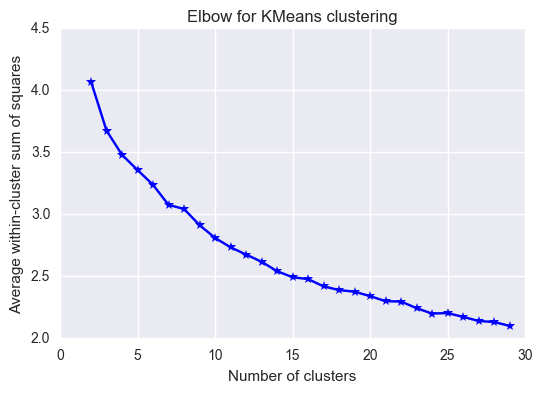

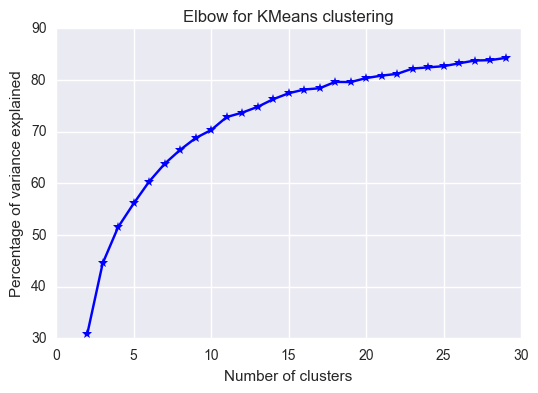

In [340]:
elbow(X, range(2,30)) 

Looking at the above figues, we can try for number of clusters = 7, since the within-cluster sum of squares is too small after 7

In [341]:
n=7

#train the model.
km=KMeans(random_state=351,n_clusters=n)
res5=km.fit(X)

#result
print(res5.labels_)

[1 6 1 6 1 6 1 1 6 6 1 6 6 6 6 6 1 5 1 1 1 1 1 1 1 6 6 6 6 5 5 5 6 1 5 0 5
 0 6 5 5 5 6 6 5 5 5 0 5 1 5 0 5 0 1 1 5 5 5 5 0 5 5 0 1 5 5 0 5 0 1 0 5 5
 0 0 5 0 0 5 1 1 1 5 5 5 5 5 0 5 0 5 5 1 0 0 0 3 0 5 0 1 1 5 0 5 5 5 5 5 0
 5 5 0 5 6 5 0 5 0 5 5 0 5 5 5 0 5 0 5 5 5 5 5 0 5 5 5 5 1 1 0 1 5 1 5 5 5
 1 5 5 1 5 5 1 1 1 5 5 1 5 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5 1 1 5 1 1 5 1 1 1
 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 4 1 4 1 1 1 4 1 1 1 4
 1 1 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 4 1 4 4 2 2 1 4 4 4 4 2 2 4 2 2 6 6
 2]


In [342]:
temporal['kmeans5'] = res5.labels_
temporal = pd.merge(temporal, nyct, on='BoroCT2010')
crs = {'init': 'epsg:4326', 'no_defs': True}
temporal = gp.GeoDataFrame(temporal, crs=crs, geometry=temporal.geometry)

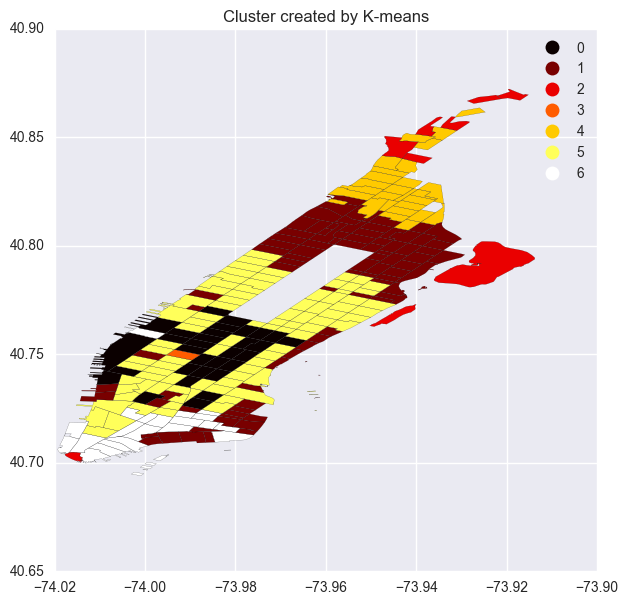

In [363]:
plt.figure(figsize=(7,7))
ax = plt.subplot(1,1,1)
temporal.plot(column='kmeans5', categorical=True, alpha = 1,\
        k=10, cmap='hot', linewidth=0.1, ax=ax, \
        legend=True)
# ax.set_axis_off()
ax.set_title('Cluster created by K-means')

We can see a distinct pattern within the clusters. The cluster no.6 are areas which have high trip duration. The upper manhattan, harlem are in different clusters, the trip duration and number of taxi trips in these areas is quite different from others.

The penn station census tract is again seen as an outlier with its own independent cluster

In [346]:
temporal.kmeans5.value_counts()

1    86
5    85
0    31
4    27
6    21
2     9
3     1
Name: kmeans5, dtype: int64

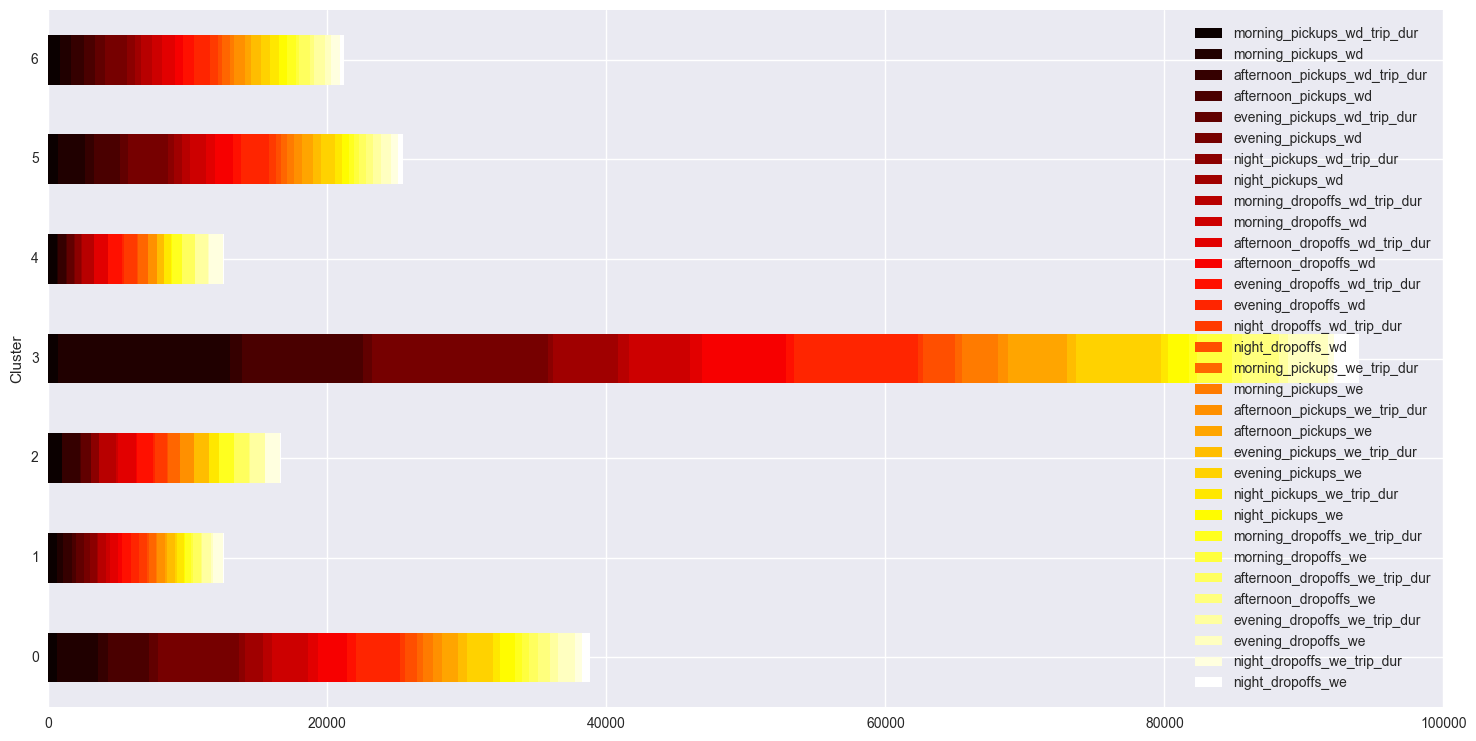

In [366]:
# cl_pcts = temporal.rename(lambda x: str(int(x)))
                
f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.iloc[:,1:].plot(kind='barh', stacked=True, ax=ax, \
             cmap='hot', linewidth=0)
ax.set_ylabel('Cluster')
ax.legend(ncol=1, loc="right");

The above figure shows the different features in each individual cluster. The cluster number 3 is kind of an anomly.